In [ ]:
#from RLTrain import Opt
import os
import time
#print(Opt())
import pandas as pd
from RadarGraph import *
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]=14.0
import sys
sys.path.append('../')

from visualization_helper import *

In [13]:
def plotabt(all_acts,actions,colors,labels,points,names,title_ext="",title=None,ylim=(-0.15,1.15)):
    """Plotting Function for actions vs time
    Inputs:
        all_act (list<np.array>) -- shape is [number of models, number of timesteps, number of actions]
        actions (list<str>) -- list of the name of each action
        colors (list<str>) -- list of colors (should be at least as long as the number of models)
        names (list<str>) -- the names of each model
        title_ext (str) -- addition you want to add to the end of the graph title
    
    """
    fig, axs = plt.subplots(figsize=(12, 7), nrows=len(actions), ncols=len(all_acts[0]))
    fig.subplots_adjust(wspace=0.0, hspace=0.0, top=0.85, bottom=0.05)
    for i,ax0 in enumerate(axs):
        for k,all_act in enumerate(all_acts):
            for j,act in enumerate(all_act):
                axs[0][j].set_title(names[j])
                ax=ax0[j]
                ax.plot(act[:,i],points[k],color=colors[k],ms=3,alpha=0.5,label=labels[k])
                ax.set_ylim(*ylim)
                if j!=0:
                    ax.set_yticks([])
                    #ax.set_yticks([int(a) for a in ylim])
        
        ax.text(act.shape[0]+2,ylim[1]*0.5,actions[i],horizontalalignment="center",verticalalignment="top")
    ax.legend()
    if title is None:
        pass#axs[0][(int(len(names)-0.5)//2)-1].text(2,2,"Average Value of Each Action vs Step %s"%title_ext)
    else:
        axs[0][(int(len(names)-0.5)//2)-1].text(2,2,title)
    #axs[0,-1].legend(names,loc=(0.8, .0))
    axs[-1,len(all_act)//2].set_xlabel("Step")
    
    


# Wurtz React

In [ ]:
parent_dir = "MODELS\\GenWurtzReact-v1"

obj = lambda x: get_conditional_rewards(x,CWtargs)[1].mean()

folders,objectives = load_rollouts(parent_dir,obj=obj,last=False)

if "Heuristic" in folders:
    gheuristic=folders["Heuristic"]
    del folders["Heuristic"]
else:
    gheuristic = pd.read_pickle("MODELS\\GenWurtzReact-v1\\Heuristic/rollout")

## Returns during Training

In [ ]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=20,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=32)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv/5,mean+stdv/5,color=colors[i],alpha=0.4,lw=0)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend(loc="lower right")    
plt.savefig("Figures/React/GenWurtzReactRuns.pdf",bbox_inches='tight')
plt.title("GenWurtzReact-v1 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

## Returns VS Targets

In [ ]:
heuristic_rewards=get_conditional_rewards(gheuristic)[1]
radar_info={a:[get_conditional_rewards(folders[a])[1]/heuristic_rewards] for a in folders}


radar_info["Heuristic"] = [heuristic_rewards]

fig,axs = stat_show(radar_info,CWtargs,["Return"],figsize=(30,7))

plt.savefig("Figures\\React\\Wurtz-best.pdf",bbox_inches="tight")

#Add in a title
fig.text(0.5, 0.8, "Average Return VS Target Material (Best model trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

## Actions vs Timestep

In [ ]:
all_acts = []
for i in range(7):
    all_act = all_acts.append(([
    actions_by_time(target_subset(folders[name],len(CWtargs),i)) for name in folders]
    +[actions_by_time(target_subset(gheuristic,len(CWtargs),i))]))

colors = ["r","g","b","c","y","m","k"]
points = ['s-', 'o-', '*-', '.-','x-',".-",".-"]
labels = CWtargs

names=[name for name in folders]+["Heuristic"]

plotabt(all_acts,["dT","dV"]+CWchoices,colors,labels,points,names)


plt.savefig("Figures\\React\\Wurtz-Actions.pdf",bbox_inches="tight")

# Fict React

In [ ]:
is_v1=True
version = ("v1" if is_v1 else "v2")

if is_v1:
    parent_dir = "MODELS\\FictReact-v1"
    FRtargs=["E","F","G","H","I"]
    FRchoices = ["A", "B", "C", "D", "F", "G" ,"H"]
else:
    parent_dir = "MODELS\\FictReact-v2"
    FRtargs=['E', 'F', 'G', 'I']
    FRchoices = ['A', 'B', 'D', 'F', 'G']
obj = lambda x: get_conditional_rewards(x,FRtargs)[1].mean()

folders,objectives = load_rollouts(parent_dir,obj=obj,last=False,verbose=False)
if "Heuristic" in folders:
    fheuristic=folders["Heuristic"]
    del folders["Heuristic"]
else:
    fheuristic = pd.read_pickle(f"MODELS\\FictReact-{version}\\Heuristic\\rollout")

## Returns during Training

In [ ]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=20,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=32)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv/5,mean+stdv/5,color=colors[i],alpha=0.4,lw=0)
    #plt.plot(np.arange(returns.shape[0])*20,returns,".",label=algo,alpha=0.3,mew=0,ms=8)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend()    
plt.savefig(f"Figures/React/FictReact-{version}Runs.pdf",bbox_inches='tight')
plt.title(f"FictReact-{version} Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

## Returns vs Targets

In [ ]:
heuristic_rewards=get_conditional_rewards(fheuristic,FRtargs)[1]
radar_info={a:[get_conditional_rewards(folders[a],FRtargs)[1]/heuristic_rewards] for a in folders}

radar_info["Heuristic"] = [heuristic_rewards]

fig,axs = stat_show(radar_info,FRtargs,["Return"],figsize=(30,7),gridlines=[0.2,0.4,0.6,0.8,1.0],rmax=1.0)
#Add in a title

plt.savefig(f"Figures\\React\\Fict-{version}-best.pdf",bbox_inches="tight")

fig.text(0.5, 0.8, "Average Return VS Target Material (Best model trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

## Actions Vs Timestep

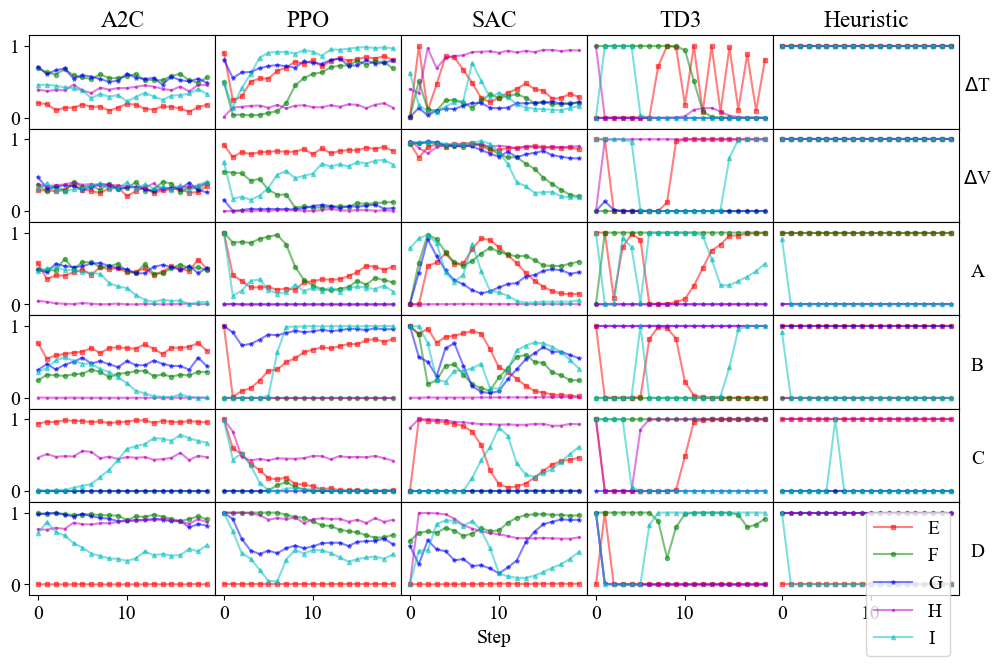

In [14]:
all_acts = []
for i in range(len(FRtargs)):
    all_act = all_acts.append(([
    actions_by_time(target_subset(folders[name],len(FRtargs),i)) for name in folders]
    +[actions_by_time(target_subset(fheuristic,len(FRtargs),i))]))

colors = ["r","g","b","m","c"]
labels = FRtargs
points = ['s-', 'o-', '*-', '.-',"^-"]
names=[name for name in folders]+["Heuristic"]

plotabt(all_acts,["$\Delta$T","$\Delta$V"]+FRchoices[:-3],colors,labels,points,names)

plt.savefig(f"Figures/React/FictReact-{version}-actions.svg",bbox_inches="tight")

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2,width_ratios=(3,1),figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=20,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=32)
    
    ax0.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    ax0.fill_between(steps,mean-stdv/5,mean+stdv/5,color=colors[i],alpha=0.4,lw=0)
    #plt.plot(np.arange(returns.shape[0])*20,returns,".",label=algo,alpha=0.3,mew=0,ms=8)
    
ax0.set_xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
ax0.set_xlabel("Step")
ax0.set_ylabel("Return")
ax0.legend()    
#plt.savefig("Legacy/Figures/FictReact/FictReactRuns.pdf",bbox_inches='tight')
#plt.title("FictReact-v2 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")


names=[a for a in folders]
fig = plt.figure(1,figsize=(2,2), dpi=240, facecolor='w', edgecolor='k')

x=np.arange(10)+1
for i in range(10):
    
    arr = [(sorted(objectives[alg])[i],j) for j,alg in enumerate(names)]
    
    for val,idx in sorted(arr,key=lambda x:-abs(x[0])):
        #print(idx,end="|")
        if i==0:
            ax1.bar(x[i],val,color=colors[idx],label=names[idx])
        else:
            ax1.bar(x[i],val,color=colors[idx])
    #print(" Iter:",i)

#plt.legend()
ax1.set_xticks([])
ax1.set_yticks([])
#plt.ylabel("Best Return")
ax1.set_xlabel("Run (sorted)")

ax0.set_ylim(-0.05,0.85)
ax1.set_ylim(-0.05,0.85)

fig.tight_layout(pad=0.0)

plt.show()

In [ ]:
!pip freeze

In [ ]:
[get_conditional_rewards(folders["PPO"],FRtargs)[1]]

In [ ]:
heuristic_rewards